In [1]:
from evoframe import get_agent_wrapper_func
from evoframe.reward_builders import RewardBuilderGame
from evoframe.population_update_builders import PopulationUpdateBuilderStatic
from evoframe.selector_function import SelectorFunctionFactory
from evoframe import PopulationManager
from evoframe.models import FeedForwardNetwork
from evoframe.models import ActivationFunctions
from evoframe.games import GuessPoint
from evoframe.games import Game

from itertools import product
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_rewards(env):
    num_epochs = len(env["rewards"].keys())
    xs = np.arange(num_epochs)
    ys = [rs[0] for rs in env["rewards"].values()]
    plt.plot(xs, ys)

# Guess the point

In [3]:
# Game
game_creation_function = lambda: GuessPoint(np.array([0.2,0.8,0.5]), np.array([0.4, 0.5, 10]))

# Model
layer_sizes = [3, 5, 3]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_sigmoid(), ActivationFunctions.get_id())

# Game-Model interface
predict_func = lambda model, inputs: model.predict(inputs)
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.get()

# Update population function
mutation_perc = 0.6
crossover_perc = 0.3
copy_perc = 0.1
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", mutation_perc, 0.3, 0.3) \
.add_operator("es_2_crossover", crossover_perc, 0.8) \
.add_operator("es_1_copy", copy_perc) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 500
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 10
last_pop, env = pm.run(num_epochs)

Epoch 0, best reward is -5.934574159008548
Epoch 1, best reward is -0.562415151595911
Epoch 2, best reward is -0.08030961080370126
Epoch 3, best reward is -0.024104134946410026
Epoch 4, best reward is -0.003800656046104967
Epoch 5, best reward is -0.0014403726775378386
Epoch 6, best reward is -0.0014403726775378386
Epoch 7, best reward is -0.0014403726775378386
Epoch 8, best reward is -0.0014403726775378386
Epoch 9, best reward is -0.0014403726775378386


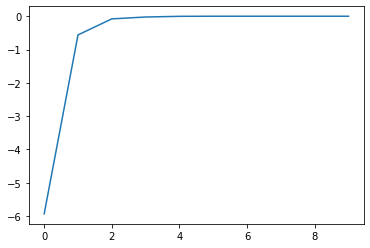

In [4]:
plot_rewards(env)

# Guess the function

In [5]:
class GuessFunction(Game):
    """This game consists in learning a function from n dimensions to m dimensions, evaluating points
        on a grid.

        1 player game.

        Agent interface:
        - input: n-dimensional np.array filled with values
        - output: m-dimensional np.array filled with values
        """
    def __init__(self, func, input_dim, input_domains, sample_every):
        self.func = func
        self.input_dim = input_dim # input dimension
        self.input_domains = input_domains # domain for each scalar in the input vector
        self.sample_every = sample_every # sampling bin for each scalar in the input vector

    def play(self, agent):
        error = 0
        ranges = []
        for i in range(self.input_dim):
            input_domain = self.input_domains[i]
            sample_every = self.sample_every[i]
            ranges.append(np.arange(input_domain[0], input_domain[1], sample_every))
        for input_tuple in product(*ranges):
            input_array = np.array(input_tuple)
            predictions = agent.predict(input_array)
            error += np.sum(np.square(self.func(input_array) - predictions))
        reward = -error
        return reward

In [6]:
# Game
game_func = lambda i: np.array([2*i[0]-3*i[1]+4, i[1]-8*i[2]-5])
input_dim = 3
input_domains = [(-1,1),(-1,1),(3,7)]
sample_every = [0.1, 0.1, 0.3]
game_creation_function = lambda: GuessFunction(game_func, input_dim, input_domains, sample_every)

# Model
layer_sizes = [3, 5, 2]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_arctan(), ActivationFunctions.get_id())

# Game-Model interface
predict_func = lambda model, inputs: model.predict(inputs)
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.get()

# Update population function
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", 0.6, 0.3, 0.5) \
.add_operator("es_2_crossover", 0.3, 0.1) \
.add_operator("es_1_copy", 0.1) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 30
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 50
last_pop, env = pm.run(num_epochs)

Epoch 0, best reward is -9534286.311560875
Epoch 1, best reward is -6987648.383535875
Epoch 2, best reward is -6490259.639731796
Epoch 3, best reward is -5149225.19563386
Epoch 4, best reward is -5149225.19563386
Epoch 5, best reward is -4546022.682501136
Epoch 6, best reward is -4397444.844161073
Epoch 7, best reward is -3879111.808629941
Epoch 8, best reward is -3474253.7502524913
Epoch 9, best reward is -3087544.725461742
Epoch 10, best reward is -3065338.4643886457
Epoch 11, best reward is -2723143.559051935
Epoch 12, best reward is -2296758.0713791284
Epoch 13, best reward is -2149211.885071764
Epoch 14, best reward is -1260881.9751794913
Epoch 15, best reward is -1340910.6618442934
Epoch 16, best reward is -959377.7539080535
Epoch 17, best reward is -1083430.563539475
Epoch 18, best reward is -823707.4236572549
Epoch 19, best reward is -745784.9174229809
Epoch 20, best reward is -609777.627201405
Epoch 21, best reward is -490541.2056098271
Epoch 22, best reward is -481059.4758902

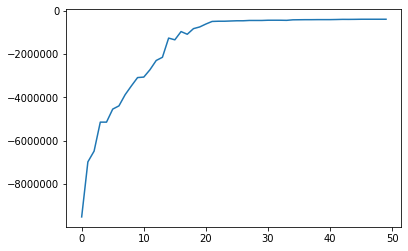

In [7]:
plot_rewards(env)

In [8]:
test_array = np.array([0.5,0.5,5])
last_pop[0].predict(test_array), game_func(test_array)

(array([[  4.65589344, -46.13080736]]), array([  3.5, -44.5]))

# Play Tris

In [27]:
PLAYER_1 = 1
PLAYER_2 = -1
EMPTY = 0
DRAW = 0
CONTINUE = 2
PLAYERS = [PLAYER_1, PLAYER_2]

class Tris(Game):
    def __init__(self):
        self.board = np.array([np.array([EMPTY for i in range(3)]) for j in range(3)])
        
    def check_win(self):
        # check rows
        board = self.board
        for row in board:
            for player in PLAYERS:
                if np.all(np.equal(row, np.full(3, player))):
                    return player
        
        # check cols
        board = self.board.transpose()
        for row in board:
            for player in PLAYERS:
                if np.all(np.equal(row, np.full(3, player))):
                    return player
                
        # check diagonals
        diags = []
        diags.append(np.array([board[i][i] for i in range(3)]))
        diags.append(np.array([board[i][3 - i - 1] for i in range(3)]))
        for row in diags:
            for player in PLAYERS:
                if np.all(np.equal(row, np.full(3, player))):
                    return player
        
        # check draw
        exist_empty = False
        for row in self.board:
            for cell in row:
                if cell == EMPTY:
                    exist_empty = True
        if not exist_empty:
            return DRAW
        
        return CONTINUE
    
    def extract_move(self, prediction):
        highest_value = -100000
        highest_value_index = -1
        for i,pred in enumerate(prediction):
            if self.board[i//3][i%3] == EMPTY and pred > highest_value:
                highest_value = pred
                highest_value_index = i
        return highest_value_index
    
    def do_move(self, move, player):
        self.board[move//3][move%3] = player
        
    def opposite_board(self):
        return np.array([np.array([PLAYER_2 if self.board[row][col] == PLAYER_1
                                   else PLAYER_1 if self.board[row][col] == PLAYER_2
                                   else EMPTY for col in range(3)]) for row in range(3)])
    
    def play(self, agent_1, agent_2, interactive=False):
        player_turn = np.random.choice(PLAYERS)
        
        if interactive:
            self.print_board() 
        
        result = self.check_win()
        while result == CONTINUE:
            if player_turn == PLAYER_1:
                prediction = agent_1.predict(self.board)
            else:
                prediction = agent_2.predict(self.opposite_board())
              
            move = self.extract_move(prediction)
            self.do_move(move, player_turn)
            
            if interactive:
                self.print_board()
            
            if player_turn == PLAYER_1:
                player_turn = PLAYER_2
            else:
                player_turn = PLAYER_1
                
            result = self.check_win()
            
        if interactive:
                self.print_board()    
        
        return result
    
    def print_board(self):
        for row in self.board:
            for cell in row:
                print(cell, end=" ")
            print("")
        print("-"*30)

In [28]:
from evoframe.reward_builders.reward_builder_game import TournamentMode

In [13]:
# Game
game_creation_function = lambda: Tris()

# Model
layer_sizes = [9, 5, 5, 9]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_sigmoid(), ActivationFunctions.get_sigmoid())

# Game-Model interface
def predict_func(model, inputs):
    # In Tris, 'inputs' is a 3x3 np.array, thus we must flatten it to a 9x1 np.array
    # output is a 9x1 vector, where the cell with highest value corresponding
    # to a valid move will be the chosen move
    return model.predict(inputs.flatten())[0]
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
# Since Tris is a two-players game, we can compute the reward with a tournament against the current generation
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_competitive_tournament(TournamentMode.VS_BEST_OF_EACH_GEN) \
.with_keep_only(30) \
.get()

# Update population function
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", 0.6, 0.3, 0.5) \
.add_operator("es_2_crossover", 0.3, 0.1) \
.add_operator("es_1_copy", 0.1) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 50
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 100
last_pop, env = pm.run(num_epochs)

Epoch 0, best reward is 1
Epoch 1, best reward is 2
Epoch 2, best reward is 3
Epoch 3, best reward is 4
Epoch 4, best reward is 5
Epoch 5, best reward is 6
Epoch 6, best reward is 7
Epoch 7, best reward is 8
Epoch 8, best reward is 9
Epoch 9, best reward is 10
Epoch 10, best reward is 11
Epoch 11, best reward is 12
Epoch 12, best reward is 13
Epoch 13, best reward is 13
Epoch 14, best reward is 12
Epoch 15, best reward is 14
Epoch 16, best reward is 15
Epoch 17, best reward is 12
Epoch 18, best reward is 15
Epoch 19, best reward is 12
Epoch 20, best reward is 15
Epoch 21, best reward is 16
Epoch 22, best reward is 16
Epoch 23, best reward is 19
Epoch 24, best reward is 20
Epoch 25, best reward is 21
Epoch 26, best reward is 22
Epoch 27, best reward is 23
Epoch 28, best reward is 23
Epoch 29, best reward is 23
Epoch 30, best reward is 25
Epoch 31, best reward is 21
Epoch 32, best reward is 22
Epoch 33, best reward is 21
Epoch 34, best reward is 23
Epoch 35, best reward is 24
Epoch 36, b

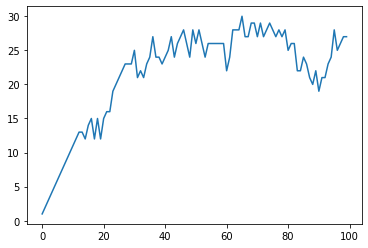

In [15]:
plot_rewards(env)

In [37]:
# Game
game_creation_function = lambda: Tris()

# Model
layer_sizes = [18, 9, 9]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_sigmoid(), ActivationFunctions.get_sigmoid())

# Game-Model interface
def predict_func(model, inputs):
    # In Tris, 'inputs' is a 3x3 np.array
    # output is a 9x1 vector, where the cell with highest value corresponding
    # to a valid move will be the chosen move
    board = inputs
    inputs = []
    for row in board:
        for cell in row:
            if cell == PLAYER_1:
                inputs += [1, 0]
            elif cell == PLAYER_2:
                inputs += [0, 1]
            else:
                inputs += [0, 0]
    return model.predict(np.array(inputs))[0]
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
# Since Tris is a two-players game, we can compute the reward with a tournament against the current generation
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_competitive_tournament(TournamentMode.VS_BEST_OF_EACH_GEN) \
.with_keep_only(30) \
.get()

# Update population function
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", 0.6, 0.3, 0.5) \
.add_operator("es_2_crossover", 0.3, 0.1) \
.add_operator("es_1_copy", 0.1) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 100
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 300
last_pop, env = pm.run(num_epochs)

Epoch 0, best reward is 1
Epoch 1, best reward is 2
Epoch 2, best reward is 3
Epoch 3, best reward is 4
Epoch 4, best reward is 5
Epoch 5, best reward is 5
Epoch 6, best reward is 7
Epoch 7, best reward is 8
Epoch 8, best reward is 9
Epoch 9, best reward is 10
Epoch 10, best reward is 9
Epoch 11, best reward is 9
Epoch 12, best reward is 10
Epoch 13, best reward is 10
Epoch 14, best reward is 11
Epoch 15, best reward is 12
Epoch 16, best reward is 11
Epoch 17, best reward is 10
Epoch 18, best reward is 9
Epoch 19, best reward is 12
Epoch 20, best reward is 11
Epoch 21, best reward is 12
Epoch 22, best reward is 14
Epoch 23, best reward is 15
Epoch 24, best reward is 13
Epoch 25, best reward is 14
Epoch 26, best reward is 14
Epoch 27, best reward is 15
Epoch 28, best reward is 13
Epoch 29, best reward is 20
Epoch 30, best reward is 15
Epoch 31, best reward is 16
Epoch 32, best reward is 20
Epoch 33, best reward is 13
Epoch 34, best reward is 20
Epoch 35, best reward is 17
Epoch 36, best

Epoch 287, best reward is 22
Epoch 288, best reward is 22
Epoch 289, best reward is 21
Epoch 290, best reward is 21
Epoch 291, best reward is 18
Epoch 292, best reward is 20
Epoch 293, best reward is 21
Epoch 294, best reward is 20
Epoch 295, best reward is 22
Epoch 296, best reward is 20
Epoch 297, best reward is 17
Epoch 298, best reward is 21
Epoch 299, best reward is 20


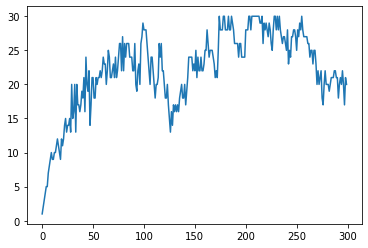

In [38]:
plot_rewards(env)

In [39]:
class AgentHuman:
    def __init__(self):
        pass
    
    def predict(self, board):
        move = int(input("Select move: "))
        prediction = [1 if i == move else 0 for i in range(9)]
        return prediction

In [43]:
game = Tris()
game.play(AgentHuman(), agent_wrapper_func(last_pop[0]), interactive=True)

0 0 0 
0 0 0 
0 0 0 
------------------------------
Select move: 0
1 0 0 
0 0 0 
0 0 0 
------------------------------
1 0 0 
0 -1 0 
0 0 0 
------------------------------
Select move: 1
1 1 0 
0 -1 0 
0 0 0 
------------------------------
1 1 0 
-1 -1 0 
0 0 0 
------------------------------
Select move: 5
1 1 0 
-1 -1 1 
0 0 0 
------------------------------
1 1 0 
-1 -1 1 
0 0 -1 
------------------------------
Select move: 6
1 1 0 
-1 -1 1 
1 0 -1 
------------------------------
1 1 -1 
-1 -1 1 
1 0 -1 
------------------------------
Select move: 0
1 1 -1 
-1 -1 1 
1 1 -1 
------------------------------
1 1 -1 
-1 -1 1 
1 1 -1 
------------------------------


0

In [ ]:
# Game
game_creation_function = lambda: Tris()

# Model
layer_sizes = [18, 9, 9]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_sigmoid(), ActivationFunctions.get_sigmoid())

# Game-Model interface
def predict_func(model, inputs):
    # In Tris, 'inputs' is a 3x3 np.array
    # output is a 9x1 vector, where the cell with highest value corresponding
    # to a valid move will be the chosen move
    board = inputs
    inputs = []
    for row in board:
        for cell in row:
            if cell == PLAYER_1:
                inputs += [1, 0]
            elif cell == PLAYER_2:
                inputs += [0, 1]
            else:
                inputs += [0, 0]
    return model.predict(np.array(inputs))[0]
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
# Since Tris is a two-players game, we can compute the reward with a tournament against the current generation
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_competitive_tournament(TournamentMode.VS_BEST_OF_EACH_GEN) \
.with_keep_only(30) \
.get()

# Update population function
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", 0.6, 0.3, 0.5) \
.add_operator("es_2_crossover", 0.3, 0.1) \
.add_operator("es_1_copy", 0.1) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 100
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 300
last_pop, env = pm.run(num_epochs)